In [1]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Helper Function

In [1]:
def display_q_value(value, title="State Action Value (Q) Function", fig_size = 12, char_size = 8): # Visualize q value
    n_state, n_action = value.shape

    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    high_color = np.array([1,1,0,0.8])
    low_color = np.array([0,0,1,0.8])
    
    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title(title,fontsize=char_size*2)  
    for i in range(8):
        for j in range(8):
            s = i*8+j
            min_q =   -1.00321235238
            max_q = 0.5868902419
            for a in range(n_action):
                val = value[s,a]
                ratio = (val - min_q)/(max_q - min_q + 1e-10) # reward color (red : high, blue : low)
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)

                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.4, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i+0.4, "{:2.3f}".format(val), fontsize=char_size)
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.2, i+0.1, "{:2.3f}".format(val), fontsize=char_size)
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.1, i-0.2, "{:2.3f}".format(val), fontsize=char_size)
    plt.xlim([-0.5,7.5])
    plt.xticks(range(8))
    plt.ylim([-0.5,7.5])
    plt.yticks(range(8))
    plt.gca().invert_yaxis()
    plt.show()
    
def display_episode(fig_size = 8, char_size = 8):
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])

    # Color
    arr_len = 0.2

    fig = plt.figure(num=0,figsize=(fig_size,fig_size))
    plt.title("Episode",fontsize=char_size*2)  
    for state, action, reward, next_state, next_action, done in episode:
        j = state%8
        i = (state - j)/8

        if action == 0: # Left arrow
            plt.arrow(j,i,-arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 1: # Down arrow
            plt.arrow(j,i,0,arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 2: # Right arrow
            plt.arrow(j,i,arr_len,0,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)
        if action == 3: # Up arrow
            plt.arrow(j,i,0,-arr_len,color="r",alpha=1,width=0.01,head_width=0.5,head_length=0.1,overhang=1)

    plt.xlim([-0.5,7.5])
    plt.xticks(range(8))
    plt.ylim([-0.5,7.5])
    plt.yticks(range(8))
    plt.gca().invert_yaxis()
    plt.show()

# Environment

In [2]:
env = CustumFrozenLakeEnv(map_name="8x8")

env.seed(seed=0)
np.random.seed(seed=0)

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_action = act_space.n
print('Action space')
print("Total {} actions".format(n_action))

env.reset()
env.render()

NameError: name 'CustumFrozenLakeEnv' is not defined

# Policy Iteration with State Action Value

Greedy policy improvement over V(s) requires model of MDP

$\pi'(a|s) = \arg\max_{a} \sum_{s'} \left(r(s,a,s') + V(s')\right) P(s'|s,a)$

However, if we compute Q(s,a) instead of V(s), then, we don't need a model for policy improvement

Greedy policy improvement over Q(s,a) is model free

$\pi'(a|s) = \arg\max_{a} Q(s,a)$

Before looking model free policy iteration, let's see how policy iteration works with state action value (Q value) when a model is given

To implement policy iteration with Q value, we have to use the Bellman eqaution for Q value as follows:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

Algorithm
--
---
Policy Evaluation

- $V_{k}(s) = \sum_{a'} \pi_{k}(a'|s) Q_{k}(s,a')$

- $Q_{k+1}(s,a) = \sum_{a'} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

Policy Improvement

- $\pi_{k+1}(a|s) = \mathbf{1}\left(a = \max_{a'} Q_{k+1}(s,a')\right)$


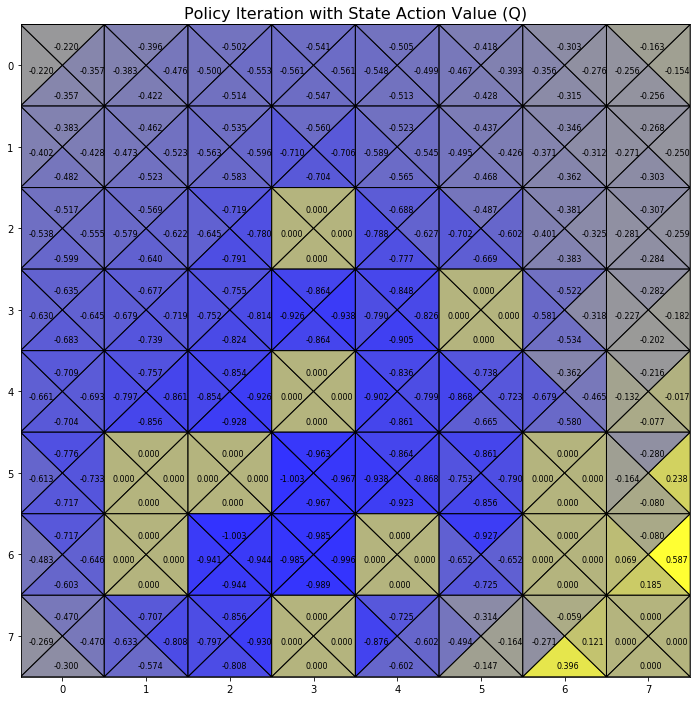

In [4]:
def q_policy_evaluation(env, P, r, policy, gamma = 0.995, epsilon = 1e-6):
    
    # Extract environment information
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_action = act_space.n
        
    # Random initial
    q = np.random.uniform(size=(n_state,n_action))
    
    while True:
        v = np.sum(policy*q,axis=1) # sum pi * Q
        q_prime = np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_action,1)))*P,axis=2) # sum (r + gamm * v ) * P
        dist = np.max(np.max(np.abs(q-q_prime)))
        q = q_prime
        if dist < epsilon:
            break
    return q

def q_policy_improvement(env, q, gamma = 0.995): # Now, we don't need a model as a input of policy improvement
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_action = act_space.n
    
    policy = np.zeros((n_state,n_action))
    policy[np.arange(n_state),np.argmax(q,axis=1)] = 1 # Greedy policy update
    
    return policy

def q_policy_iteration(env):
    
    obs_space = env.observation_space
    act_space = env.action_space
    n_state = obs_space.n
    n_action = act_space.n
    
    # Random initial policy
    policy = np.random.uniform(size=(n_state,n_action))
    policy = policy/np.sum(policy,axis=1,keepdims=True)
    
    P = np.zeros((n_state,n_action,n_state))
    r = np.zeros((n_state,n_action,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
            
    while True:
        q = q_policy_evaluation(env, P, r, policy) # Evaluate value of current policy
        policy_prime = q_policy_improvement(env, q) # Find greedy policy

        if (policy == policy_prime).all(): # If policy doesn't change, stop
            break
        policy = policy_prime # update new policy
    
    return policy, q
    
if __name__=='__main__':
    policy,q = q_policy_iteration(env)
    display_q_value(q,title="Policy Iteration with State Action Value (Q)") 

# Monte Carlo Policy Iteration

For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

The update rule for Q value is changed to

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t} - Q_{old}(S_{t}, A_{t}))$

We can update our estimator after the episode is terminated

Given $(S_{0}, A_{0}, R_{1}, S_{1}, A_{1}, R_{2}, \dots, S_{T}, A_{T}, R_{T+1}, S_{T+1})$,

$G_{t}$ can be computed using

$G_t = R_{t+1} + \gamma G_{t+1}$

Algorithm
--
---
For every episodes

Policy Evaluation

- $G = \text{array}[|\mathcal{S}|, |\mathcal{A}|]$

- $g = 0$

- For $t = T$ to $t = 0$

- $g = R_{t+1} + \gamma g$

- $G[S_{t}, A_{t}] = g$

- end for

- $Q = Q + \alpha ( G - Q )$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [5]:
class MCAgent():
    def __init__(self, n_state, n_action, epsilon=1.0, alpha=0.1, gamma=0.995):
        
        self.n_state = n_state
        self.n_action = n_action
        
        # initial Q value
        self.q = np.zeros([n_state,n_action])
        
        # memory for saving trajectory
        self.samples = []
        
        self.epsilon = epsilon # initial epsilon
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor 

    def save_sample(self, state, action, reward, done): # Save experience (s, a, r)
        self.samples.append([state, action, reward, done])
        
    def update_value(self):
        q_old = self.q
        g = 0
        G = np.zeros([self.n_state,self.n_action])
        for t in reversed(range(len(self.samples))): # reverse way
            state, action, reward, _ = self.samples[t]
            g = reward + self.gamma * g # r + gamma G_t
            G[state][action] = g # Store it
        
        self.q = q_old + self.alpha*(G - q_old) # Update
        self.samples = [] # empty memory
        
    def update_policy(self, update_rate):
        self.epsilon = self.epsilon*np.min([update_rate,1]) # Decay epsilon
        
    def get_action(self, state): # epsilon Greedy action
        if np.random.uniform() < self.epsilon: # choose random action with probability epsilon 
            action = np.random.randint(0, high=self.n_action)
        else: # choose greedy action with probability (1-epsilon)
            action = np.argmax(self.q[state])
        return action
       
if __name__=='__main__': 
    mcagent = MCAgent(n_state,n_action)

# Run MC Agent

In [ ]:
n_episode = 10000
for episode in range(n_episode):
    state = env.reset()
    action = mcagent.get_action(state)
    done = False
    while not done: # If the epsiodes finish, then escape the loop    
        
        next_state, reward, done, info = env.step(action)
        next_action = mcagent.get_action(next_state) # Get next action

        mcagent.save_sample(state, action, reward, done) # Store samples
        
        state = next_state
        action = next_action
        
    mcagent.update_value() # Update Q value using sampled epsiode
    mcagent.update_policy(1000/(episode+1)) # Decaying epsilon
display_q_value(mcagent.q,title="Monte Carlo Policy Iteration")